In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q fdd444d3007a2f4c408956b5aca0fad667dd98f4
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [1]:
from MI_prediction.Utils.Datasets import DataLoader, DataLoader_Rest, get_epochs, get_runs
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from mne.preprocessing import compute_current_source_density

# Lawhern2018 sklearn

## BCI2a

### Load data

In [2]:
dl = DataLoader(dataset_name="BNCI2014001")
dl.load_data(subject_ids=[3])

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


In [26]:
dl2 = copy.deepcopy(dl)

In [23]:
def filterbank_preprocessor(freqs):
    FB = {}
    for freq in freqs:
        print('band to filter: {} Hz'.format(freq))
        FB[str(freq[0])+'_'+str(freq[1])] = Preprocessor('filter', l_freq=freq[0], h_freq=freq[1])
    return FB


In [24]:
fb = filterbank_preprocessor([(4,8),(8,12)])

band to filter: (4, 8) Hz
band to filter: (8, 12) Hz


In [31]:
fb

{'4_8': <braindecode.preprocessing.preprocess.Preprocessor at 0x2a38f07f0>,
 '8_12': <braindecode.preprocessing.preprocess.Preprocessor at 0x29caf58b0>}

In [52]:
def filterbank(ds, preprocess = [], filters = [], standarization = [], channels_prep = []):
    ds_filt = []
    for i in filters.keys():
        d_tmp = copy.deepcopy(ds)
        preprocessors = preprocess + channels_prep + [filters[i]] + standarization
        d_tmp.preprocess_data(preprocessors=preprocessors)
        ds_filt.append(d_tmp)
    return ds_filt

In [60]:
preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter', l_freq=1., h_freq=None)  # Bandpass filter
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

In [61]:
Ch_prep

In [62]:
ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=Ch_prep)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Fitted sphere radius:         85.2 mm
Origin head coordinates:      -0.7 9.9 58.4 mm
Origin device coordinates:    -0.7 9.9 58.4 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Up

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Fitted sphere radius:         85.2 mm
Origin head coordinates:      -0.7 9.9 58.4 mm
Origin device coordinates:    -0.7 9.9 58.4 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Up

In [63]:
ds_f

In [24]:
low_cut_hz = 4.
high_cut_hz = 38.
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
        #Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
        #        factor_new=factor_new, init_block_size=init_block_size),
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

dl.preprocess_data(preprocessors=preprocessors)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Fitted sphere radius:         85.2 mm
Origin head coordinates:      -0.7 9.9 58.4 mm
Origin device coordinates:    -0.7 9.9 58.4 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         85.2 mm
Origin head coordinates:      -0.7 9.9 58.4 mm
Origin device coordinates:    -0.7 9.9 58.4 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Fitted sphere radius:         85.2 mm
Origin head coordinates:      -0.7 9.9 58.4 mm
Origin device coordinates:    -0.7 9.9 58.4 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

In [348]:
trials = dl.get_trials(start_offset=[0], end_offset=[0])

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching even

In [349]:
X,y = get_epochs(trials['win_0'].split('session')['session_T'])

In [350]:
idx_2class = (y==0)+(y==1)
X2 = X[idx_2class,:,:]
y2 = y[idx_2class]

In [351]:
X.shape

(288, 22, 1000)

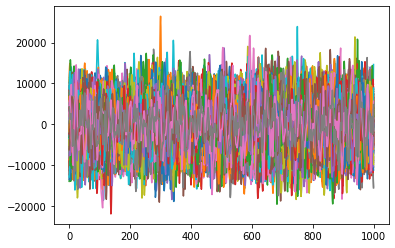

In [352]:
plt.plot(X[:,2,:].T)
plt.show()

### CSP + LDA

In [353]:
preds = []
y_true = []
acc = []
c = 0
seed = 1234

skf = StratifiedKFold(n_splits=4)

lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)
scaler = StandardScaler()
clf = Pipeline([('CSP', csp),('Scaler',scaler), ('LDA', lda)])

scores = cross_val_score(clf, X2.astype('float'), y2, cv=skf, n_jobs=-1,verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.5e+04 (2.2e-16 eps * 22 dim * 3.1e+18  max singular value)
    Using tolerance 1.5e+04 (2.2e-16 eps * 22 dim * 3e+18  max singular value)
    Using tolerance 1.5e+04 (2.2e-16 eps * 22 dim * 3e+18  max singular value)
    Estimated rank (mag): 22
    Estimated rank (mag): 22
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
    MAG: rank 22 computed from 22 data channels with 0 projectors
    MAG: rank 22 computed from 22 data channels with 0 projectors
    Using tolerance 1.5e+04 (2.2e-16 eps * 22 dim * 3.1e+18  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Reducing data rank from 22 -> 22
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Est

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


In [354]:
scores

array([1.        , 0.94444444, 0.91666667, 0.86111111])

In [355]:
np.mean(scores)

0.9305555555555556